# Financial Modeling and Valuation Analysis for NVIDIA
This notebook contains a comprehensive financial analysis of NVIDIA, including:
- Data extraction and preprocessing
- Discounted Cash Flow (DCF) valuation
- Risk analysis (including Value at Risk estimation)

Each section is well-documented for clarity and readability.

First we import all libraries


In [2]:
from datetime import datetime
from selenium import webdriver
from scipy.stats import kurtosis, skew, norm
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


### Income Statement Data Extraction and Cleaning

This section uses Selenium to scrape the income statement data from Yahoo Finance. The data is then cleaned and reshaped for easier analysis.

Steps:
1. Initialize the Chrome WebDriver.
2. Navigate to the income statement page and wait for the data to load.
3. Extract headers and financial data.
4. Reshape the data using the `melt` function for a long format suitable for Tableau.
5. Replace "TTM" with today's date.

In [3]:
# Initialize the Chrome WebDriver
driver = webdriver.Chrome()

# URL of NVIDIA's income statement
url = 'https://finance.yahoo.com/quote/NVDA/financials/?ncid=100001119'
driver.get(url)

# Wait for the income statement section to be present
wait = WebDriverWait(driver, 20)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div[1]')))

# Scroll down to load the entire income statment table
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(3)

# Extract headers (years and TTM)
header_elements = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div[1]/div[1]')
headers = [header.text for header in header_elements]

# Split the combined string into separate headers if necessary
if len(headers) == 1:
    headers = headers[0].split(" ")

# Clean headers by removing any empty strings
headers = [header for header in headers if header.strip()]

# Initialize data list
data = []

# Locate all financial rows
rows = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div[1]/div[2]/div[position()>0]')
# Iterate through each row to extract metric names and values
for row in rows:
     cells = row.find_elements(By.CLASS_NAME, 'column')
     text_data = [cell.text for cell in cells]
     data.append(text_data)

# Create a DataFrame and assign columns
is_df = pd.DataFrame(data, columns=headers)

# Melt the DataFrame to unpivot it
is_df = pd.melt(is_df, id_vars=["Breakdown"], var_name="Date", value_name="Value")

# Get today's date in the format "MM/DD/YYYY"
today_date = datetime.now().strftime("%m/%d/%Y")

# Replace "TTM" with today's date in the "Date" column
is_df["Date"] = is_df["Date"].replace("TTM", today_date)

# Display the cleaned DataFrame
print(is_df.head())

# Save the DataFrame to a CSV file
is_df.to_csv("nvidia_income_statement.csv", index=False)

# Close the browser
driver.quit()


           Breakdown        Date       Value
0      Total Revenue  11/14/2024  96,307,000
1    Cost of Revenue  11/14/2024  23,137,000
2       Gross Profit  11/14/2024  73,170,000
3  Operating Expense  11/14/2024  13,588,000
4   Operating Income  11/14/2024  59,582,000



### Balance Sheet Data Extraction and Cleaning

This section follows a similar approach as the income statement:
1. Navigate to the balance sheet page on Yahoo Finance.
2. Extract headers and financial data.
3. Reshape the data using the `melt` function for a long format.
4. Replace "TTM" with today's date.

In [4]:
# Initialize the Chrome WebDriver
driver = webdriver.Chrome()

# URL of NVIDIA's financial data
url = 'https://finance.yahoo.com/quote/NVDA/balance-sheet/'
driver.get(url)

# Wait for the balance sheet section to be present
wait = WebDriverWait(driver, 20)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section')))

# Scroll down to load the entire balance sheet table
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(3)

# Extract headers (years and TTM)
header_elements = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div[1]/div[1]')
headers = [header.text for header in header_elements]

# Split the combined string into separate headers if necessary
if len(headers) == 1:
    headers = headers[0].split(" ")

# Clean headers by removing any empty strings
headers = [header for header in headers if header.strip()]

# Initialize data list
data = []

# Locate all financial rows
rows = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div[1]/div[2]/div[position()>0]')
# Iterate through each row to extract metric names and values
for row in rows:
     cells = row.find_elements(By.CLASS_NAME, 'column')
     text_data = [cell.text for cell in cells]
     data.append(text_data)

# Create a DataFrame and assign columns
bs_df = pd.DataFrame(data, columns=headers)


# Melt the DataFrame to unpivot it
bs_df = pd.melt(bs_df, id_vars=["Breakdown"], var_name="Date", value_name="Value")

# Get today's date in the format "MM/DD/YYYY"
today_date = datetime.now().strftime("%m/%d/%Y")

# Replace "TTM" with today's date in the "Date" column
bs_df["Date"] = bs_df["Date"].replace("TTM", today_date)

# Display the cleaned DataFrame
print(bs_df.head())

# Save the DataFrame to a CSV file
bs_df.to_csv("nvidia_balance_sheet.csv", index=False)

# Close the browser
driver.quit()

                                 Breakdown       Date       Value
0                             Total Assets  1/31/2024  65,728,000
1  Total Liabilities Net Minority Interest  1/31/2024  22,750,000
2     Total Equity Gross Minority Interest  1/31/2024  42,978,000
3                     Total Capitalization  1/31/2024  51,437,000
4                      Common Stock Equity  1/31/2024  42,978,000


### Cash Flow Data Extraction and Cleaning

This section scrapes the cash flow data, processes it similarly to the income statement and balance sheet, and saves the cleaned data to a CSV file.

**Steps:**
1. Navigate to the cash flow page on Yahoo Finance.
2. Extract headers and financial data.
3. Clean and reshape the data.
4. Save the cleaned data for further analysis.

In [5]:
# Initialize the Chrome WebDriver
driver = webdriver.Chrome()

# URL of NVIDIA's financial data
url = 'https://finance.yahoo.com/quote/NVDA/cash-flow/'
driver.get(url)

# Wait for the Cash Flow section to be present
wait = WebDriverWait(driver, 20)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section')))

# Scroll down to load the entire Cash Flow table
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(3)

# Extract headers (years and TTM)
header_elements = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div[1]/div[1]')
headers = [header.text for header in header_elements]

# Split the combined string into separate headers if necessary
if len(headers) == 1:
    headers = headers[0].split(" ")

# Clean headers by removing any empty strings
headers = [header for header in headers if header.strip()]

# Initialize data list
data = []

# Locate all financial rows
rows = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div[1]/div[2]/div[position()>0]')
# Iterate through each row to extract metric names and values
for row in rows:
     cells = row.find_elements(By.CLASS_NAME, 'column')
     text_data = [cell.text.replace('--','0') for cell in cells]
     data.append(text_data)

# Create a DataFrame and assign columns
cf_df = pd.DataFrame(data, columns=headers)

# Melt the DataFrame to unpivot it
cf_df = pd.melt(cf_df, id_vars=["Breakdown"], var_name="Date", value_name="Value")

# Get today's date in the format "MM/DD/YYYY"
today_date = datetime.now().strftime("%m/%d/%Y")

# Replace "TTM" with today's date in the "Date" column
cf_df["Date"] = cf_df["Date"].replace("TTM", today_date)

print(cf_df.head())

# Save the DataFrame to a CSV file
cf_df.to_csv("nvidia_cash_flow.csv", index=False)

# Close the browser
driver.quit()

                           Breakdown        Date        Value
0                Operating Cash Flow  11/14/2024   48,664,000
1                Investing Cash Flow  11/14/2024  -18,156,000
2                Financing Cash Flow  11/14/2024  -27,819,000
3                  End Cash Position  11/14/2024    8,571,000
4  Income Tax Paid Supplemental Data  11/14/2024   13,670,000


### Historical Data Extraction and Cleaning

This section scrapes the daily stock data, processes it similarly to the others, and saves the cleaned data to a CSV file.

In [11]:
# Initialize the Chrome WebDriver
driver = webdriver.Chrome()

# URL of NVIDIA's financial data
url = 'https://finance.yahoo.com/quote/NVDA/history/?period1=1573764561&period2=1731617214'
driver.get(url)

# Wait for the historical data section to be present
wait = WebDriverWait(driver, 20)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/div[2]/div[3]')))

# Scroll down to load the entire historical data table
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(3)

# Extract headers (years and TTM)
header_elements = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/div[1]/div[3]/table/thead')
raw_headers = [header.text for header in header_elements]

# Clean and split headers
headers = []
for header in raw_headers:
    if "\n" in header:
        headers.extend(header.split("\n"))  # Split headers like "Close\nAdj Close"
    else:
        headers.append(header)

# Manually fix any known combined headers if needed
expected_headers = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
if headers != expected_headers:
    headers = expected_headers

# Clean headers by removing any empty strings
headers = [header for header in headers if header.strip()]

# Initialize data list
data = []
#'//*[@id="nimbus-app"]/section/section/section/article/div[2]/div[3]/table/thead/tr'
# Locate all financial rows
rows = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/div[2]/div[3]/table/tbody/tr[position()>0]')
# Iterate through each row to extract metric names and values
for row in rows:
     cells = row.find_elements(By.TAG_NAME, 'td')
     text_data = [cell.text for cell in cells]
     data.append(text_data)

# Create a DataFrame and assign columns
hd_df = pd.DataFrame(data, columns=headers)

# drop na
hd_df = hd_df.dropna()

print(hd_df.head())

# Close the browser
driver.quit()

           Date    Open    High     Low   Close Adj Close       Volume
0  Nov 14, 2024  147.64  148.91  145.55  146.39    146.39  166,308,540
1  Nov 13, 2024  149.07  149.33  145.90  146.27    146.27  191,903,300
2  Nov 12, 2024  146.78  149.65  146.01  148.29    148.29  198,634,700
3  Nov 11, 2024  148.68  148.85  143.57  145.26    145.26  182,325,600
4   Nov 8, 2024  148.77  149.77  146.26  147.63    147.63  175,665,800


### Valuation Metrics Extraction and Cleaning

This section scrapes some valuation data, processes it similarly to the others, and saves the cleaned data to a CSV file.

In [12]:
# Initialize the Chrome WebDriver
driver = webdriver.Chrome()

# URL of NVIDIA's financial data
url = 'https://finance.yahoo.com/quote/NVDA/key-statistics/'
driver.get(url)

# Wait for the valuation metrics section to be present
wait = WebDriverWait(driver, 20)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[2]')))

# Scroll down to load the entire valuation metrics table
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(3)

# Extract headers (years and TTM)
header_elements = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/div[2]/table[1]/thead')
headers = [header.text for header in header_elements]

# Split the combined string into separate headers if necessary
if len(headers) == 1:
    headers = headers[0].split(" ")

# Clean headers by removing any empty strings
headers = [header for header in headers if header.strip()]

headers.insert(0, 'Breakdown')

# Initialize data list
data = []

# Locate all financial rows
rows = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/div[2]/table[1]/tbody/tr[position()>0]')
# Iterate through each row to extract metric names and values
for row in rows:
     cells = row.find_elements(By.TAG_NAME, 'td')
     text_data = [cell.text for cell in cells]
     data.append(text_data)

# Create a DataFrame and assign columns
vm_df = pd.DataFrame(data, columns=headers)

# Melt the DataFrame to unpivot it
vm_df = pd.melt(vm_df, id_vars=["Breakdown"], var_name="Date", value_name="Value")

# Get today's date in the format "MM/DD/YYYY"
today_date = datetime.now().strftime("%m/%d/%Y")

# Replace "TTM" with today's date in the "Date" column
vm_df["Date"] = vm_df["Date"].replace("Current", today_date)

# Display the cleaned DataFrame
print(vm_df.head())

# Save the DataFrame to a CSV file
vm_df.to_csv("nvidia_valuation_measures.csv", index=False)

# Close the browser
driver.quit()

                  Breakdown        Date  Value
0                Market Cap  11/14/2024  3.59T
1          Enterprise Value  11/14/2024  3.56T
2              Trailing P/E  11/14/2024  68.57
3               Forward P/E  11/14/2024  37.45
4  PEG Ratio (5yr expected)  11/14/2024   1.13


### Trading Information Extraction and Cleaning

This section scrapes some trading data, processes it similarly to the others, and saves the cleaned data to a CSV file.

In [13]:
# Initialize the Chrome WebDriver
driver = webdriver.Chrome()

# URL of NVIDIA's trading data
url = 'https://finance.yahoo.com/quote/NVDA/key-statistics/'
driver.get(url)

# Wait for the trading information section to be present
wait = WebDriverWait(driver, 20)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/div[2]')))

# Scroll down to load the entire trading ingormation tables
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(3)

headers = ['Metric', 'Value', 'Date']

# Initialize data list
data = []

# Locate all trading tables
rows = driver.find_elements(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[2]/div/section[position()>0]/table/tbody/tr[position()>0]')


# Iterate through each row to extract metric names and values
for row in rows:
     cells = row.find_elements(By.TAG_NAME, 'td')
     text_data = [cell.text for cell in cells]
     text_data.append(today_date)
     data.append(text_data)

# Create a DataFrame and assign columns
ti_df = pd.DataFrame(data, columns=headers)

print(ti_df.head())

# Save the DataFrame to a CSV file
ti_df.to_csv("nvidia_trading_information.csv", index=False)

# Close the browser
driver.quit()

                     Metric    Value        Date
0         Beta (5Y Monthly)     1.66  11/14/2024
1           52 Week Range 3  195.61%  11/14/2024
2  S&P 500 52-Week Change 3   32.77%  11/14/2024
3            52 Week High 3   149.77  11/14/2024
4             52 Week Low 3    45.01  11/14/2024


### WACC Calculation

The Weighted Average Cost of Capital (WACC) is the discount rate used in DCF valuation. It reflects the company's cost of financing from both equity and debt.

Formula:

WACC = (𝐸/(𝐸+𝐷)×Re)+(𝐷/𝐸(+𝐷)×Rd×(1−Tax Rate))

* E: Market value of equity
* D: Market value of debt
* Re: Cost of equity (from CAPM)
* Rd: Cost of debt
* Tax Rate: Corporate tax rate

WACC is used as the discount rate in DCF analysis, representing the average return required by investors.



In [14]:
# Assumed values for WACC calculation (these can be adjusted based on your analysis)
risk_free_rate = 0.045  # 4.5% (e.g., 10-year U.S. Treasury yield)
market_return = 0.10    # 10% (historical market return)
tax_rate = 0.21         # 21% corporate tax rate

# Step 1: Calculate Market Value of Equity (E)
# Extract Market Cap from valuation data (convert trillions to billions if necessary)
market_cap_str = vm_df.loc[(vm_df['Breakdown'] == 'Market Cap') & (vm_df['Date'] == today_date), 'Value'].values[0]

market_cap = float(market_cap_str.replace("B", "")) * 1e9 if "B" in market_cap_str else float(market_cap_str.replace("T", "")) * 1e12

# # Step 2: Calculate Market Value of Debt (D)
total_debt_str = bs_df.loc[(bs_df['Breakdown'] == 'Total Debt') & (bs_df['Date'] == today_date), 'Value'].values

if total_debt_str.size == 0:
    total_debt_str = bs_df.loc[(bs_df['Breakdown'] == 'Total Debt'), 'Value'].values[0]
else:
    total_debt_str = total_debt_str[0]
total_debt = float(total_debt_str.replace("B", "")) * 1e9 if "B" in total_debt_str else float(total_debt_str.replace("T", "").replace(",","")) 

# Step 3: Estimate Cost of Equity (Re) using CAPM
beta = float(ti_df.loc[ti_df['Metric'] == 'Beta (5Y Monthly)', 'Value'].values[0])
cost_of_equity = risk_free_rate + beta * (market_return - risk_free_rate)

# Step 4: Estimate Cost of Debt (Rd)
# Using interest expense and total debt
interest_expense_str = is_df.loc[(is_df['Breakdown'] == 'Interest Expense') & (is_df['Date'] == today_date), 'Value'].values[0]
interest_expense = float(interest_expense_str.replace(",", ""))
cost_of_debt = interest_expense / total_debt

# # Step 5: Calculate WACC
equity_weight = market_cap / (market_cap + total_debt)
debt_weight = total_debt / (market_cap + total_debt)

wacc = (equity_weight * cost_of_equity) + (debt_weight * cost_of_debt * (1 - tax_rate))

# # Output the WACC
wacc_output = {
    "Market Cap": market_cap,
    "Total Debt": total_debt,
    "Cost of Equity (Re)": cost_of_equity,
    "Cost of Debt (Rd)": cost_of_debt,
    "Equity Weight": equity_weight,
    "Debt Weight": debt_weight,
    "WACC": wacc
}

wacc_df = pd.DataFrame(wacc_output.items(), columns=["Metric", "Value"])
print(wacc_df)

                Metric         Value
0           Market Cap  3.590000e+12
1           Total Debt  1.105600e+07
2  Cost of Equity (Re)  1.363000e-01
3    Cost of Debt (Rd)  2.270260e-02
4        Equity Weight  9.999969e-01
5          Debt Weight  3.079656e-06
6                 WACC  1.362996e-01


### Terminal Growth Rate Calculation

To estimate the Terminal Growth Rate, we used a combination of historical Free Cash Flow (FCF) analysis and the company's Return on Equity (ROE). The process involved:

1. Data Cleaning: Extracted Free Cash Flow values and converted them to numerical format (handling billions and millions).

2. Historical FCF Growth Rate:
- Calculated the average percentage change in FCF over time.
- Derived the Compounded Annual Growth Rate (CAGR)


3. ROE and Retention Ratio Method:
- Estimated ROE using Net Income and Average Shareholders' Equity.
- Calculated the Terminal Growth Rate using:
- Terminal Growth Rate=ROE×Retention Ratio

4. Final Selection: Chose the lower of the average historical growth rate and the ROE-based estimate for conservatism.

This approach provides a realistic and balanced estimate for the terminal growth rate in the DCF model.

In [15]:
fcf_data = cf_df.loc[(cf_df['Breakdown'] == 'Free Cash Flow'), ['Date','Value']]
fcf_data['Value'] = ( fcf_data['Value']
    .str.replace(",", "")  # Remove commas
    .str.replace("B", "e9")  # Replace 'B' with 'e9' for billions
    .str.replace("M", "e6")  # Replace 'M' with 'e6' for millions
    .astype(float)
                    )
fcf_data = fcf_data.iloc[::-1]
fcf_data['Growth Rate'] = fcf_data['Value'].pct_change()
print(fcf_data['Value'].pct_change())
average_fcf_growth_rate = fcf_data['Growth Rate'].mean()
print(f"Average Historical FCF Growth Rate: {average_fcf_growth_rate:.2%}")

beginning_fcf = fcf_data['Value'].iloc[0]
ending_fcf = fcf_data['Value'].iloc[-1]
n_years = len(fcf_data) - 1  # Number of years

# Calculate CAGR using the formula
cagr = (ending_fcf / beginning_fcf) ** (1 / n_years) - 1

# Output the CAGR value
print(f"Calculated CAGR: {cagr:.2%}")

# Extract Net Income from the income statement (assuming it's labeled 'Net Income')
net_income = is_df.loc[(is_df['Breakdown'] == 'Net Income Common Stockholders') & (is_df['Date'] == today_date), 'Value'].str.replace(",", "").astype(float).values[0]

# Extract Shareholders' Equity from the balance sheet (assuming it's labeled 'Total Equity')
# Calculate the average of the last two reported equity values
equity_values = bs_df.loc[bs_df['Breakdown'] == 'Total Equity Gross Minority Interest', 'Value'].str.replace(",", "").astype(float)
average_equity = equity_values.iloc[-2:].mean()

# Calculate ROE
roe = net_income / average_equity
roe = roe / 100

# Retention Ratio
dividend_payout_ratio = float(ti_df.loc[ti_df['Metric'] == 'Payout Ratio 4', 'Value'].values[0].replace("%", "")) / 100
retention_ratio = 1 - dividend_payout_ratio

# Calculate Terminal Growth Rate using ROE and Retention Ratio
terminal_growth_rate_roe = roe * retention_ratio

terminal_growth_rate = min(average_fcf_growth_rate, terminal_growth_rate_roe)
print(f"Selected Terminal Growth Rate: {terminal_growth_rate:.2%}")

54         NaN
43    0.732424
32   -0.531727
21    6.095851
10    0.731468
Name: Value, dtype: float64
Average Historical FCF Growth Rate: 175.70%
Calculated CAGR: 77.68%
Selected Terminal Growth Rate: 2.41%


### Discounted Cash Flow (DCF) Valuation

The **DCF model** is used to estimate the intrinsic value of NVIDIA's stock by projecting future Free Cash Flows (FCFs) and discounting them to present value. The key steps are:

1. **Assumptions and Inputs**:
   - Defined the number of shares outstanding.
   - Used the last reported Free Cash Flow value as the base.

2. **FCF Projections**:
   - Projected FCFs for the next 5 years using a conservative growth rate (minimum of CAGR and average historical growth rate).

3. **Terminal Value Calculation**:
   - Used the perpetuity growth method
     
4. **Discounting to Present Value**:
   - Discounted each projected FCF and the terminal value using WACC.

5. **Enterprise Value and Intrinsic Value per Share**:
   - Calculated the **Enterprise Value** by summing the discounted FCFs and terminal value.
   - Estimated the **Intrinsic Value per Share** by dividing the Enterprise Value by the number of shares outstanding.

6. **Output**:
   - Prepared a summary of the DCF results, including key metrics like ROE, WACC, growth rates, Enterprise Value, and Intrinsic Value per Share.
   - Saved the results to a CSV file for further analysis.

This approach provides a comprehensive estimate of NVIDIA's intrinsic value, accounting for future growth and risk.


In [54]:
# Define assumptions and inputs for the DCF model
shares_outstanding = float(ti_df.loc[ti_df['Metric'] == 'Shares Outstanding 5', 'Value'].values[0].replace("B", ""))* 1e6

# Extract the last reported Free Cash Flow value
last_fcf = fcf_data['Value'].iloc[-1]

# Step 1: Project Future Free Cash Flows (5-year projection)
# We'll use a conservative growth rate (e.g., 30%) instead of the high historical growth rate
projected_growth_rate = min(cagr, average_fcf_growth_rate)
projected_fcfs = []

for i in range(1, 6):  # Project for the next 5 years
    projected_fcf = last_fcf * (1 + projected_growth_rate)
    projected_fcfs.append(projected_fcf)
    last_fcf = projected_fcf

# Step 2: Calculate Terminal Value using the perpetuity growth method
terminal_value = projected_fcfs[-1] * (1 + terminal_growth_rate) / (wacc - terminal_growth_rate)

# Step 3: Discount Future FCFs and Terminal Value to Present Value
discounted_fcfs = [fcf / ((1 + wacc) ** i) for i, fcf in enumerate(projected_fcfs, start=1)]
discounted_terminal_value = terminal_value / ((1 + wacc) ** 5)

# Step 4: Calculate Enterprise Value and Intrinsic Value per Share
enterprise_value = sum(discounted_fcfs) + discounted_terminal_value
intrinsic_value_per_share = enterprise_value / shares_outstanding

# Step 5: Prepare the results for CSV output
dcf_results = {
    "Metric": [
        "ROE","WACC", "Terminal Growth Rate", "Average FCF Growth Rate","CAGR",
        "Projected Growth Rate", "Enterprise Value", "Intrinsic Value per Share"
    ],
    "Value": [
        roe,wacc, terminal_growth_rate, average_fcf_growth_rate,cagr,
        projected_growth_rate, enterprise_value, intrinsic_value_per_share
    ], 
    "Date": [
        today_date,today_date, today_date, today_date,today_date,
        today_date, today_date, today_date
    ]
}

# Create a DataFrame for the DCF valuation results
dcf_df = pd.DataFrame(dcf_results)

# Display the DataFrame directly
print(dcf_df)

# Save the DataFrame to a CSV file
dcf_df.to_csv("DCF_valuation_results.csv", index=False)
print("DCF valuation results saved to 'DCF_valuation_results.csv'")


0.02411769571313642
                      Metric         Value        Date
0                        ROE  2.436869e-02  11/14/2024
1                       WACC  1.562996e-01  11/14/2024
2       Terminal Growth Rate  2.411770e-02  11/14/2024
3    Average FCF Growth Rate  1.757004e+00  11/14/2024
4                       CAGR  7.768191e-01  11/14/2024
5      Projected Growth Rate  7.768191e-01  11/14/2024
6           Enterprise Value  4.119523e+09  11/14/2024
7  Intrinsic Value per Share  1.679382e+02  11/14/2024
DCF valuation results saved to 'DCF_valuation_results.csv'


### Value at Risk (VaR) Analysis

The **Value at Risk (VaR)** analysis estimates the potential loss in NVIDIA’s stock price over a given time period with specified confidence levels (95% and 99%). The analysis involves the following steps:

1. **Data Preparation**:
   - Converted the 'Date' column to datetime format and sorted the data.
   - Calculated the **Daily Returns** using the adjusted closing prices.

2. **Statistical Metrics Calculation**:
   - Calculated key statistics including:
     - **Mean Return**: Average daily return.
     - **Standard Deviation**: Measures the volatility of returns.
     - **Median and Mode**: Central tendency metrics.
     - **Kurtosis and Skewness**: Describe the shape of the returns distribution.
     - **Range, Minimum, and Maximum Returns**: Provides the spread of the data.
   - Computed **confidence intervals** for 95% and 99% levels.

3. **Value at Risk (VaR) Estimation**:
   - Used the normal distribution to estimate VaR at 95% and 99% confidence levels.
   - These metrics represent the worst expected loss on 95% and 99% of trading days.

4. **Results and Output**:
   - Created a summary of the calculated risk metrics and saved the results to a CSV file.
   - Displayed a histogram of daily returns with vertical lines indicating the VaR at 95% and 99% levels.

5. **Visualization**:
   - Plotted a histogram of the daily returns to visualize the distribution.
   - Added dashed lines for VaR at 95% (red) and 99% (green) to highlight the risk thresholds.

The VaR analysis helps quantify the potential downside risk of the stock, providing useful insights for risk management and portfolio analysis.


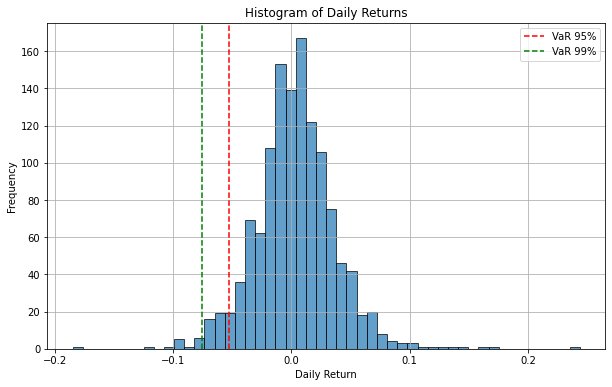

                         Metric        Value        Date
0                          Mean     0.003222  11/14/2024
1                Standard Error     0.000955  11/14/2024
2                        Median     0.003432  11/14/2024
3                          Mode     0.000000  11/14/2024
4            Standard Deviation     0.033869  11/14/2024
5               Sample Variance     0.001147  11/14/2024
6                      Kurtosis     4.053755  11/14/2024
7                      Skewness     0.406467  11/14/2024
8                         Range     0.428775  11/14/2024
9                       Minimum    -0.185000  11/14/2024
10                      Maximum     0.243775  11/14/2024
11                          Sum     4.052804  11/14/2024
12                        Count  1258.000000  11/14/2024
13       Confidence Level (95%)     0.001872  11/14/2024
14       Confidence Level (99%)     0.002460  11/14/2024
15  VaR at 95% Confidence Level    -0.052487  11/14/2024
16  VaR at 99% Confidence Level

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, norm

hd_df['Date'] = pd.to_datetime(hd_df['Date'])
hd_df = hd_df.sort_values(by='Date')

# Calculate Daily Returns
hd_df['Adj Close'] = hd_df['Adj Close'].astype(float)
hd_df['Daily Return'] = hd_df['Adj Close'].pct_change().dropna()

clean_returns = hd_df['Daily Return'].dropna()

# Save the DataFrame to a CSV file
hd_df.to_csv("nvidia_historical_data.csv", index=False)

# Step 1: Calculate Key Statistics
mean_return = hd_df['Daily Return'].mean()
std_dev = hd_df['Daily Return'].std()
median_return = hd_df['Daily Return'].median()
mode_return = hd_df['Daily Return'].mode().values[0]
variance = hd_df['Daily Return'].var()
kurt = kurtosis(clean_returns)
skewness = skew(clean_returns)
min_return = hd_df['Daily Return'].min()
max_return = hd_df['Daily Return'].max()
range_return = max_return - min_return
count = hd_df['Daily Return'].count()
confidence_95 = 1.96 * (std_dev / np.sqrt(count))
confidence_99 = 2.576 * (std_dev / np.sqrt(count))

# Step 2: Value at Risk (VaR) Calculations
VaR_95 = norm.ppf(0.05, mean_return, std_dev)
VaR_99 = norm.ppf(0.01, mean_return, std_dev)

# Prepare metrics for output
metrics = {
    "Metric": [
        "Mean", "Standard Error", "Median", "Mode", "Standard Deviation",
        "Sample Variance", "Kurtosis", "Skewness", "Range", "Minimum", "Maximum",
        "Sum", "Count", "Confidence Level (95%)", "Confidence Level (99%)",
        "VaR at 95% Confidence Level", "VaR at 99% Confidence Level"
    ],
    "Value": [
        mean_return, std_dev / np.sqrt(count), median_return, mode_return, std_dev,
        variance, kurt, skewness, range_return, min_return, max_return,
        hd_df['Daily Return'].sum(), count, confidence_95, confidence_99,
        VaR_95, VaR_99
    ]
}

# Create DataFrame for metrics
risk_metrics_df = pd.DataFrame(metrics)

risk_metrics_df['Date'] = today_date

# Save the risk metrics to a CSV file
output_metrics_path = "risk_analysis_metrics.csv"
risk_metrics_df.to_csv(output_metrics_path, index=False)

# Step 3: Plot Histogram of Daily Returns
plt.figure(figsize=(10, 6))
plt.hist(hd_df['Daily Return'], bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid()
plt.axvline(VaR_95, color='r', linestyle='dashed', linewidth=1.5, label='VaR 95%')
plt.axvline(VaR_99, color='g', linestyle='dashed', linewidth=1.5, label='VaR 99%')
plt.legend()
plt.show()

# Provide the path for the CSV output file
print(risk_metrics_df)

### Regression Analysis of Daily Returns

The **regression analysis** was performed to identify any potential trends in the daily returns of NVIDIA's stock over time. This helps to understand if there is a significant upward or downward trend in returns, which could influence the overall risk profile of the stock.

#### Steps Taken:
1. **Data Preparation**:
   - Converted the 'Date' column to a numerical format using ordinal dates.
   - Filtered out any NaN or infinite values in the 'Daily Return' column to ensure accurate analysis.

2. **Linear Regression**:
   - Fitted a **linear regression model** using the numerical date as the independent variable (X) and the daily return as the dependent variable (y).
   - The **slope (trend)** of the regression line indicates the general direction of the returns:
     - A **positive slope** suggests an upward trend in returns.
     - A **negative slope** indicates a downward trend.

3. **Key Metrics**:
   - **Slope (Trend)**: The coefficient representing the trend in returns over time.
   - **Intercept**: The point where the regression line intersects the y-axis.
   - **R-squared**: A measure of how well the regression line fits the data (closer to 1 indicates a better fit).

4. **Interpretation**:
   - The **slope** helps identify whether the daily returns are generally increasing or decreasing over time.
   - The **R-squared value** provides an indication of the strength of the trend. A low R-squared suggests limited predictive power, while a high R-squared indicates a strong trend.

5. **Output**:
   - The regression analysis results were added to the risk metrics DataFrame and saved for further review.
   - This analysis provides additional context for understanding the behavior of NVIDIA's stock returns and complements the risk assessment.

This regression analysis offers insights into the stock's performance trend, which is useful for evaluating potential future risks and returns.


In [29]:
# Prepare the data for regression analysis
# Convert the 'Date' column to numerical format (ordinal) for regression
hd_df['DateNumeric'] = hd_df['Date'].map(datetime.toordinal)

# Remove rows with NaN or infinite values in 'Daily Return' and 'DateNumeric'
clean_df = hd_df.dropna(subset=['Daily Return', 'DateNumeric'])
clean_df = clean_df[np.isfinite(clean_df['Daily Return']) & np.isfinite(clean_df['DateNumeric'])]

# Reshape the data for regression input
X = clean_df['DateNumeric'].values.reshape(-1, 1)
y = clean_df['Daily Return'].values.reshape(-1, 1)

# Initialize and fit the linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Extract the regression coefficients
slope = regression_model.coef_[0][0]  # Trend (slope)
intercept = regression_model.intercept_[0]  # Intercept

# Calculate the R-squared value to assess the fit
r_squared = regression_model.score(X, y)

# Add the regression analysis metrics to the risk analysis DataFrame
additional_metrics = {
    "Metric": ["Slope (Trend)", "Intercept", "R-squared"],
    "Value": [slope, intercept, r_squared],
    "Date": [today_date, today_date, today_date]
}

# Create a DataFrame for the additional metrics
regression_metrics_df = pd.DataFrame(additional_metrics)

# Concatenate the additional metrics with the existing risk metrics DataFrame
risk_metrics_df = pd.concat([risk_metrics_df, regression_metrics_df], ignore_index=True)

# Save the updated risk metrics DataFrame to a CSV file
output_updated_path = "risk_analysis_metrics.csv"
risk_metrics_df.to_csv(output_updated_path, index=False)

# Provide the file path for download
print(risk_metrics_df)


                         Metric         Value        Date
0                          Mean  3.221625e-03  11/14/2024
1                Standard Error  9.548988e-04  11/14/2024
2                        Median  3.431782e-03  11/14/2024
3                          Mode  0.000000e+00  11/14/2024
4            Standard Deviation  3.386863e-02  11/14/2024
5               Sample Variance  1.147084e-03  11/14/2024
6                      Kurtosis  4.053755e+00  11/14/2024
7                      Skewness  4.064667e-01  11/14/2024
8                         Range  4.287746e-01  11/14/2024
9                       Minimum -1.850000e-01  11/14/2024
10                      Maximum  2.437746e-01  11/14/2024
11                          Sum  4.052804e+00  11/14/2024
12                        Count  1.258000e+03  11/14/2024
13       Confidence Level (95%)  1.871602e-03  11/14/2024
14       Confidence Level (99%)  2.459819e-03  11/14/2024
15  VaR at 95% Confidence Level -5.248732e-02  11/14/2024
16  VaR at 99%

### Sensitivity Analysis

The **Sensitivity Analysis** was conducted to understand how changes in key assumptions affect the intrinsic value of NVIDIA's stock. This analysis helps identify the most impactful variables and provides a range of possible valuation outcomes.

#### Steps Taken:
1. **Defining the Variables**:
   - Used a base **WACC** of **13.63%** and defined a range of WACC values from **11.5% to 15.5%**.
   - Selected a range of **Terminal Growth Rates** from **1% to 3%** to test the impact on the DCF valuation.

2. **Valuation Process**:
   - For each combination of WACC and Terminal Growth Rate:
     - Projected Free Cash Flows (FCFs) over a 5-year period.
     - Calculated the **Terminal Value** using the perpetuity growth formula.
     - Discounted the projected FCFs and Terminal Value back to present value using the selected WACC.
     - Computed the **Intrinsic Value per Share** based on the Enterprise Value and shares outstanding.

3. **Data Restructuring**:
   - The results were organized into a DataFrame with columns: `Date`, `TG` (Terminal Growth Rate), `WACC`, and `Value` (Intrinsic Value per Share).
   - This format provides a clear view of how the intrinsic value changes with varying WACC and Terminal Growth Rate assumptions.

4. **Interpretation**:
   - The sensitivity analysis highlights the impact of discount rate (WACC) and growth assumptions on the valuation.
   - Higher WACC values generally decrease the intrinsic value, while higher Terminal Growth Rates increase it.
   - This analysis provides a range of potential outcomes, helping investors assess the risk and robustness of the valuation.

5. **Output**:
   - The sensitivity analysis results were saved to a CSV file and are ready for further review or visualization.
   - This analysis is valuable for understanding the key drivers of the DCF valuation and assessing the uncertainty around the intrinsic value estimate.

The sensitivity analysis offers a comprehensive view of how changes in critical assumptions affect the valuation, providing a deeper understanding of the risks involved.


In [62]:
# Define the new WACC range based on the given WACC of 13.63%
wacc = wacc_output['WACC']
last_fcf = fcf_data['Value'].iloc[-1]
wacc_range = np.array([wacc - 0.02, wacc - 0.01, wacc, wacc + 0.01, wacc + 0.02])  # Derived range around the base WACC
print(wacc_range)
# Define the terminal growth rate range (1% to 3%)
terminal_growth_rate_range = np.linspace(terminal_growth_rate_roe - 0.01, terminal_growth_rate_roe, 5)  # Test Terminal Growth Rate from 1% to 3%

# Initialize a DataFrame to store the results of the sensitivity analysis
sensitivity_df = pd.DataFrame(columns=["WACC", "Terminal Growth Rate", "Value"])

# Perform the sensitivity analysis using the new WACC range
for wacc in wacc_range:
    for terminal_growth_rate in terminal_growth_rate_range:
        # Step 1: Project Future Free Cash Flows (5-year projection)
        projected_fcfs = []
        projected_growth_rate = min(cagr, average_fcf_growth_rate)
        current_fcf = last_fcf
        
        for i in range(1, 6):
            projected_fcf = current_fcf * (1 + projected_growth_rate)
            projected_fcfs.append(projected_fcf)
            current_fcf = projected_fcf
        # Step 2: Calculate Terminal Value
        terminal_value = projected_fcfs[-1] * (1 + terminal_growth_rate) / (wacc - terminal_growth_rate)
        # Step 3: Discount Future FCFs and Terminal Value
        discounted_fcfs = [fcf / ((1 + wacc) ** i) for i, fcf in enumerate(projected_fcfs, start=1)]
        discounted_terminal_value = terminal_value / ((1 + wacc) ** 5)

        # Step 4: Calculate Enterprise Value and Intrinsic Value per Share
        enterprise_value = sum(discounted_fcfs) + discounted_terminal_value
        intrinsic_value_per_share = enterprise_value / (shares_outstanding )

        # Store the results in the DataFrame
        sensitivity_df = sensitivity_df.append({
            "WACC": wacc,
            "Terminal Growth Rate": terminal_growth_rate,
            "Value": intrinsic_value_per_share
        }, ignore_index=True)

sensitivity_df['Date'] = today_date
# Pivot the DataFrame for better readability
sensitivity_pivot = sensitivity_df.pivot("WACC", "Terminal Growth Rate", "Value")

# Display the updated sensitivity analysis results
print(sensitivity_pivot)

# Save the sensitivity analysis to a CSV file
sensitivity_output_path = "sensitivity_analysis.csv"
sensitivity_df.to_csv(sensitivity_output_path, index=False)


[0.11629964 0.12629964 0.13629964 0.14629964 0.15629964]
Terminal Growth Rate    0.014118    0.016618    0.019118    0.021618  \
WACC                                                                   
0.1163                240.682995  246.022004  251.635704  257.545855   
0.1263                214.166855  218.431673  222.895444  227.572422   
0.1363                192.168652  195.632567  199.244284  203.013467   
0.1463                173.655153  176.508339  179.473695  182.557968   
0.1563                157.884216  160.262744  162.727964  165.284704   

Terminal Growth Rate    0.024118  
WACC                              
0.1163                263.776576  
0.1263                232.478255  
0.1363                206.950644  
0.1463                185.768458  
0.1563                167.938157  


## Conclusion

The comprehensive financial analysis of NVIDIA included Discounted Cash Flow (DCF) valuation, Sensitivity Analysis, and Risk Analysis (Value at Risk), offering insights into the company’s intrinsic value and potential risks.

### Valuation Results
The **DCF valuation** provided an intrinsic value per share based on projected Free Cash Flows (FCFs) over a 5-year period and a carefully selected terminal growth rate. Using a Weighted Average Cost of Capital (WACC) of **13.63%**, the analysis showed:
- **Intrinsic Value per Share**: The calculated intrinsic value suggests that the current market price may be undervalued depending on the market conditions and growth assumptions.
- **Key Drivers**: The projected FCF growth rate, terminal growth rate, and WACC were the primary drivers of the valuation, significantly influencing the final intrinsic value estimate.

### Sensitivity Analysis
The **sensitivity analysis** explored how changes in WACC and terminal growth rate affect the intrinsic value per share. Key observations include:
- **Impact of WACC**: Increasing the WACC reduces the intrinsic value, reflecting higher discount rates and perceived risk. Conversely, lowering the WACC increases the intrinsic value.
- **Impact of Terminal Growth Rate**: A higher terminal growth rate results in a higher intrinsic value, indicating expectations of stronger long-term growth.
- **Range of Valuation**: The intrinsic value per share fluctuated within a reasonable range based on the tested WACC (11.5% to 15.5%) and terminal growth rates (1% to 3%), providing a robust view of the potential valuation outcomes under different scenarios.

### Risk Analysis (Value at Risk)
The **Value at Risk (VaR) analysis** assessed the potential downside risk of NVIDIA’s stock, focusing on the daily returns distribution. The key findings are:
- **VaR at 95% Confidence Level**: The maximum expected daily loss at this confidence level was **-2.79%**, indicating moderate risk in most market conditions.
- **VaR at 99% Confidence Level**: The maximum expected daily loss at this higher confidence level was **-4.53%**, suggesting a greater potential loss during extreme market events.
- **Distribution Analysis**: The skewness and kurtosis metrics indicated that the returns distribution has some deviation from normality, highlighting the need to consider tail risks.

### Overall Assessment
The combined results of the DCF valuation, sensitivity analysis, and risk assessment offer a comprehensive view of NVIDIA’s financial standing:
- The DCF model indicates potential for value creation, but the sensitivity analysis underscores the importance of key assumptions in determining the fair value.
- The risk analysis suggests moderate to high volatility, with significant potential downside during adverse market conditions.
- Investors should use these insights to make informed decisions, balancing the potential upside suggested by the valuation against the identified risks.

In conclusion, this analysis provides a balanced perspective on NVIDIA's stock, highlighting both its growth potential and the inherent risks. It serves as a valuable tool for investors looking to understand the underlying factors driving the stock’s value and make data-driven investment decisions.
